In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import math

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error

Using Theano backend.


## Introduction
Technical analysis is a trading discipline used to evaluate investments and identify trading opportunities in price trends and patterns from graphs.  Technical analysts believe past trading activity and price changes of a stock can be valuable indicators of the security's future price movements.  The difference bewteen 
technical analysis and fundamental analysis is that fundamental analyats focuses on a company's financials rather than historical price patterns or stock trends.
This notebook will demonstrate how to perform a very basic technical analysis of stock prices using Python code.  I will provide analysis and insights of stock prices that can be obtained from historical stock data and corresponding graphs.  In addition, this notebook will demonstrate how algorithmic trading can be used to predict stock prices and how technical indicators can used with LTSM models.  <br>
I obtained historical stock data by using the Pandas library DataReader.  The library provides price and volumne information regarding stocks. I will use mainly the Closing Pricefrom the datasets.<br>
I will examine how Long Short Term Memory (LSTM ) and SARIMA models can be used to forecast the next day stock price.  I will use key metrics to measure the performance of the models at predicting stock prices. 
My analysis will focus the following pharmaceutical companies that are developing a COVID-19 vaccine: 
* Pfizer(PFE),
* Johnson & Johnson(JNJ)
* Moderna (MRNA)
* Novavax (NVAX) 
* BioNTech SE(BNTX)
* MERCK & Co.(MRK)


### Question 1: 
Can technical indicators provide enough information to make a decision of when to buy and sell stocks?  A question to consider is what type of investment is being sought?  Are you looking for short investments with high returns or long term investment with consistent returns.<br>
**Model 1** is a historical price change analysis.<br>
Will use Moving Averages, prices changes and MACD to analyze price trends.  
### Question 2:
How well can historical data  and algorithms predict future stocks prices?  I will contrast the performance of predictions of LSTM models and LTSM models with technical indicators.  Is there a differnce in the RMSE metrics when comparing models?<br>
**Model 1** I will use a LTSM Neural Network to make a price prediction with only historical price data.<br>
**Model 2** LTSM model with technical indicators to predict and graph future stock prices.<br>
### Question 3:
Which trading algorithms LTSM or ARIMA performs better at predicting stocks prices?  
**Model 1** is an ARIMA model.<br>
### Question 4:
Is there a relationship between tweets put out by the pharmaceutical companies and the fluctuation in their stock prices.<br>




## Get the Historical Stock Data

### Multiple Stocks Data

In [2]:
from datetime import date
today = date.today()
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            plt.title("HistoricL Stock Adjusted Price Data")
            plt.xlabel('Dates')
            plt.ylabel('Stock Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


In [3]:
# multi_stock_data = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=True, stock_value='Adj Close')
# multi_stock_data;

In [4]:
#multi_stock_data.to_csv('multi_pharm_data')

In [5]:
#start='2017',end='today'
multi_stocks = pd.read_csv('multi_pharm_data', parse_dates=True, index_col='Date')
#multi_stocks

In [6]:
def get_multi_plot(df, stock_value=None):
    #plt.figure(figsize=(12,8))
    df.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel('Close Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
    return df
    

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,104.081535,25.400000,NaN,23.886580,NaN
2017-01-04,26.887548,103.910828,26.200001,NaN,24.076221,NaN
2017-01-05,27.146002,104.998009,26.400000,NaN,24.731359,NaN
2017-01-06,27.041008,104.494850,27.400000,NaN,24.507233,NaN
2017-01-09,27.032928,104.476868,28.400000,NaN,24.593435,NaN
...,...,...,...,...,...,...
2021-02-08,34.820000,164.919998,319.929993,185.979996,50.060001,119.500000
2021-02-09,34.970001,166.270004,315.869995,179.520004,50.410000,117.529999
2021-02-10,34.740002,166.809998,298.359985,179.339996,49.970001,119.349998


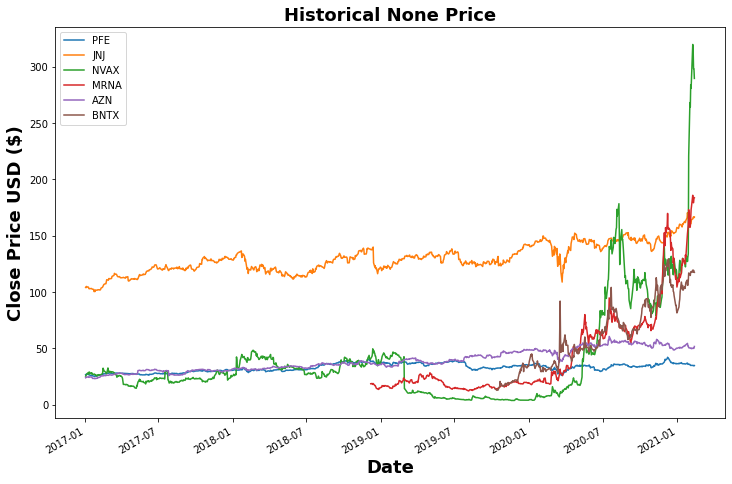

In [7]:
get_multi_plot(multi_stocks)

### Single Stock Data

In [8]:
def single_stock_data(symbol, start,end=None,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single

    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Dataframe has 1040 rows and 6 columns



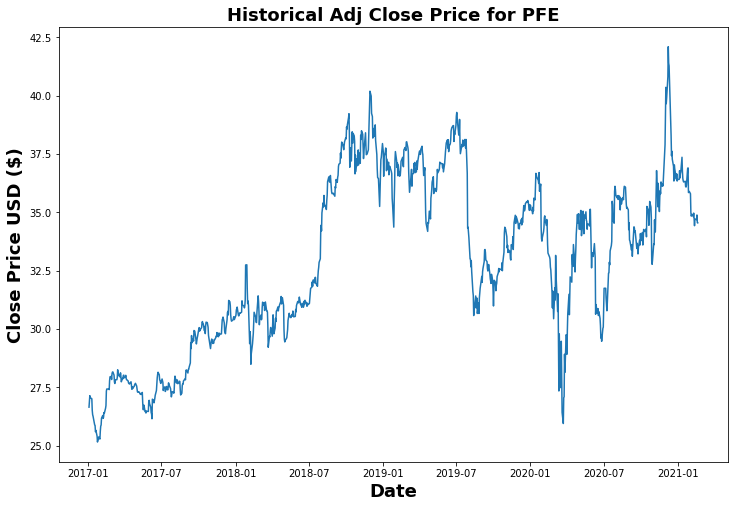

In [9]:
start='01-01-2019'
end='today'
pfe_stock = single_stock_data('PFE', start='01-01-2017',end='today',plot=True,stock_value='Adj Close')

In [10]:
#pfe_stock.to_csv('pfe_stock')
pfe_stock_data = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')
#single_stock['Close']['2015-04-01':'2015-12-01'].plot()
pfe_stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.653324
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928
...,...,...,...,...,...,...
2021-02-12,34.950001,34.360001,34.439999,34.720001,25513100.0,34.720001
2021-02-16,34.860001,34.560001,34.849998,34.689999,28668400.0,34.689999
2021-02-17,35.000000,34.459999,34.570000,34.889999,26389400.0,34.889999


In [12]:
pfe_stock_data['Adj Close'].describe()

count    1040.000000
mean       32.850950
std         3.707581
min        25.159119
25%        29.999429
50%        33.001329
75%        36.119614
max        42.101986
Name: Adj Close, dtype: float64

In [13]:
25.159119-42.101986

-16.942866999999996

In [15]:
(-16.942866999999996 / 25.159119) *100

-67.3428469415006

## Technical Indicators
The pratice of analyzing and executing stock trades is becoming increasingly automated with algorithimic trading.  The usage of technnical indicators is a part of algorithmic trading.    Technical analysis is a trading discipline used to evaluate  investments and identify trading opportunities by analyzing statistical trends gathered from trading activity, such as price movement and volume.  What are technical indicators and how are used by Technical Analyst in stock trading?  Technical indicators are approaches or pattern-based signals produced by the price, volume, and/or open interest of a stock which are used by traders who follow technical analysis.  echnical analysts believe past trading activity and price changes of a security can be valuable indicators of the security's future price movements.https://www.investopedia.com/terms/t/technicalindicator.asp<br>Technical analysts look for indicators in the historical data and use them to predict future price movements.  The analysts also use them to look for entry and exit points in markets to conduct trades.  I will discuss popular technical indicators that are used in the markets to study price movements:

1. Moving Averages (MA)
2. Exponential Moving Average (EMA)
3. Rate of Change (ROC)

### Moving Averages
The moving average is also known s the rolling mean.  Moving averages smooth the curve by filtering out the noise inorder to highlight components in the data such as trends and seasonality.  The moving Average smooths out the variations in the dataset by calculating the moving average.  Three common types of moving averages are Simple Moving Average (SMA), Weighted Moving Average (WMA) and Exponential Moving Average (EMA).  The commonly used moving averages are 5, 10, 20, 50, 200 day moving averages.  A 10 period SMA would be over 10 periods and woud mean 10 trading days).
<br>
#### Simple Moving Average
The Simple Moving Average is the arithmetic mean of all the stock prices or the sum of all the stock prices divided by the number of periods.  We can use the rolling method to calcualte moving averages.<br>
<br>
The below plot shows alot of fluctuations and noise in the stock price.  However, the plot shows the average stock price with the 10 and 20-year moving averages.

In [ ]:
rolling_method = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')
#how big should the subset of data be that we're calculating the moving average on?
rolling_method['MA_10'] = rolling_method.Close.rolling(10).mean()
rolling_method['MA_20'] = rolling_method.Close.rolling(20).mean()
rolling_method['2017-01-01':'2021-2-19']

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(rolling_method['Close'], label='PFE')
plt.plot(rolling_method['MA_10'], label='MA 10 Day')
plt.plot(rolling_method['MA_20'],label='MA 20 Day')
plt.xlabel('Dates')
plt.ylabel('Stock Prices')
plt.legend(loc='lower right', fontsize=14)

#### Exponential Moving Average (EMA)
 The EMA is also referred to as the exponentially weighted moving average.  The difference between EMA and SMA is that SMA assigns equal weight to all periods.  Whereas, with EMA the latest prices are given higher weights and it assigns lesser weight to past data.  EMA is used more by short term traders because it is quicker to react to price changes compared to SMA which is slower. this technical indicator is used to produce buy and sell signals based on crossovers and divergences from the historical average.  https://www.investopedia.com/terms/e/ema.asp<b>
When red line crosses above the green line you see a increase in the price and every time the red drops below the EMA26 you see the price decrease.

In [ ]:
pfe_df = pfe_stock_data.copy()

In [ ]:
# #single_stock
# #good time of when to buy stockand when to sell it
# #three moving avrages
# #short/fast exponential moving ma
def create_ema_fuction(data, col='Close',span1=None,span2=None,span3=None):
    data['shortEMA'] = data[col].ewm(span=span1, adjust=False).mean() #5 time periods
    #calculate middle/medium exponential moving ma
    data['middleEMA'] = data[col].ewm(span=span2, adjust=False).mean() #5 time periods
    #calculate long/slow exponential moving ma
    data['longEMA'] = data[col].ewm(span=span3, adjust=False).mean() #5 time periods
    
    #visulaize closing price and exponential moving average
    plt.figure(figsize=(12,6))
    plt.plot(data[col],label='Close Price', color='blue')
    plt.plot(data['shortEMA'],label='Short/Fast EMA', color='red')
    plt.plot(data['middleEMA'],label='Middle/medium EMA', color='orange')
    plt.plot(data['longEMA'],label='Long/slow EMA', color='green')
    plt.title('Exponential Moviing Average Plot')
    plt.xlabel('Dates')
    plt.ylabel('Closing Price')
    plt.legend()
    
    return data #, shortEMA, middleEMA,longEMA

In [ ]:
ewma1 = create_ema_fuction(data=pfe_df, span1=5, span2=21,span3=63)
ewma1.head()

In [ ]:
#function to buy and sell the stock
#buy sell signals
def buy_sell_function(data):
    buy_list = []
    sell_list=[]
    flag_long = False
    flag_short = False

    for i in range(0, len(data)):
        if data['middleEMA'][i] < data['longEMA'][i] and data['shortEMA'][i]< data['middleEMA'][i] and flag_long== False and flag_short== False:
                #this is when to buy stock
                buy_list.append(data['Close'][i])
                sell_list.append(np.nan)
                flag_short = True
        #sell if the short/fast moving average crosses above the middle moving average
        elif flag_short == True and data['shortEMA'][i] > data['middleEMA'][i]:
            sell_list.append(data['Close'][i])
            buy_list.append(np.nan)
            flag_short = False
            
        elif data['middleEMA'][i] > data['longEMA'][i] and data['shortEMA'][i]> data['middleEMA'][i] and flag_long== False and flag_short== False:
                #this is when to buy stock
                buy_list.append(data['Close'][i])
                sell_list.append(np.nan)
                flag_long = True
        #sell if the short/fast moving average crosses above the middle moving average
        elif flag_long == True and data['shortEMA'][i] < data['middleEMA'][i]:
            sell_list.append(data['Close'][i])
            buy_list.append(np.nan)
            flag_long = False 
        else:
            #if conditions not met for any statement just append to buy, sell lists a nan value
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
           
    return buy_list, sell_list       
            

In [ ]:
#add buy and sell signals to dataset
ewma1['Buy'] = buy_sell_function(pfe_df)[0] #return index 0
ewma1['Sell'] = buy_sell_function(pfe_df)[1] #return inddex 1

In [ ]:
def ema_signals_function(data):
    plt.figure(figsize=(12,8))
    plt.plot(data['Close'],label='Close Price', color='blue',alpha=0.35)
    plt.plot(data['shortEMA'],label='Short/Fast EMA', color='red',alpha=0.35)
    plt.plot(data['middleEMA'],label='Middle/medium EMA', color='orange',alpha=0.35)
    plt.plot(data['longEMA'],label='Long/slow EMA', color='green',alpha=0.35)
    plt.scatter(data.index,data['Buy'], color='green', marker='^', alpha=1)
    #prices are going to go down
    plt.scatter(data.index,data['Sell'], color='red',marker='v',alpha=1)
    plt.title('Buy and Sell Graph')
    plt.legend() 

In [ ]:
ema_signals_function(data=ewma1)

## Rate of Change
### Historical Price Change Analysis
volatility is the range of price change security experiences over a given period of time. If the price stays relatively stable, the security has low volatility. A highly volatile security hits new highs and lows quickly, moves erratically, and has rapid increases and dramatic falls.Is volatility in price good or bad for trading? As the price fluctuates, it provides the opportunity for investors to buy stock in a solid company when the price is very low, and then wait for cumulative growth down the road.https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp

### Price Change in Dollars
Add column to calculate actual change in dollars<br>
To see how big the changes were on a daily basis we subtract yesterday's closing price yesterday from today.  This will show the change in price.  For example, we can see that on 1/3 the Closing price was 39.886147 and on 1/2 the Closing price was 41.034157 so the price decreased -$1.148.<br> 
Expected change (1 std deviaiton movement in price)<br>
Column of calculation of how big the actual changes was interms of standard deviations.<br>
Histograms changes in standard deviaiton<br>
Scatterplot of absolute value of magnitude change vs. actual change. Let's us see how the price changes daily.<br>

In [ ]:
# sdr = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=False, stock_value='Adj Close')
# sdr
price_change = single_stock.copy()

In [ ]:
#leavr off 1 b/c that's default value
#using shift function
#price decreased by -$1.148

price_change['Actual_Changes'] = price_change['Close'] - price_change['Close'].shift(1)
# price_change['Expected_Changes'] =price_change['Close'] * #std deviation or 21 day 
price_change

The below graph shows that for the stated time the stock price never increased more than 3.00 and did not decrease more than -3.00.<br>

In [ ]:
#the mean (average) change was less than 1 cent
price_change['Actual_Changes'].describe() 

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(price_change['Actual_Changes'])

### Price Volatility
volatility is the range of price change security experiences over a given period of time. If the price stays relatively stable, the security has low volatility. A highly volatile security hits new highs and lows quickly, moves erratically, and has rapid increases and dramatic falls.
For short-term traders, volatility is even more crucial. Day traders work with changes that occur second-to-second, minute-to-minute. If there is no price change, there is no profit.https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp
THe column 'change' shows how volatile the price change percentage wise.  The graph shows that the data points are now centered aound 0. The graph shows that around 3/20 was a volatile period for the stock price and it increase above 7% and decreased 7%.<br>

In [ ]:
#calculate historical volatility
prct_change = price_change.copy()
prct_change['change'] = np.log(prct_change['Close'] / prct_change['Close'].shift()) #divide by previous days close

In [ ]:
prct_change

In [ ]:
#graph centered around 0
#price only went up 7% twice and around 3/20 went down below 7% a few times
#8/19 went below &%
plt.figure(figsize=(12,6))
plt.plot(prct_change['change'])

### Historical Volatility

In [ ]:
#use  rolling standard deviation to get that 
#use 21 day rolling window b/c there are 21 traing days in a month on average
#this will include 21st observation
#but volatility should be used from next day
prct_change['Volatility'] = prct_change['change'].rolling(21).std().shift(1)

In [ ]:
#what price volatility looks like over time
#4/20 was a highly volatile period
prct_change['Volatility'].plot()

In [ ]:
#use rolling standard deviation to ge that. Use 21 day rolling window.
#use today's volatility at close today to predcit a 1 std move tomorrow
prct_change['Expected_Change'] = prct_change['Close'].shift(1) * prct_change['Volatility'] #1 std or 21 day rolling std
prct_change = prct_change.iloc[1:]
prct_change

In [ ]:
#magnitude of change
#divide actual change by expected change
#end up w/values in standard deviations
prct_change['Magnitude'] = prct_change['Actual_Changes'] / prct_change['Expected_Change']

In [ ]:
#idea of typical distrubution of changes in terms of standard deviation
#mostly w/in 3 stadnard deviaitons of mean
#could be more of positve change
#kind of equal happening on positve and negative side
plt.hist(prct_change['Magnitude'], bins='auto')

In [ ]:

sdr = multi_stocks.pct_change(1)
sdr

In [ ]:
(26.887548/26.653324) - 1

In [ ]:
# #visualize stocks daily returns
# plt.figure(figsize=(12,6))
# #loop through each stock and plot simple returns
# for c in d_simple_returns.columns.values:
#     plt.plot(d_simple_returns.index, d_simple_returns[c], label=c)
# #plt.title(title)
# #plt.ylabel(col + ' Price', fontsize=18)
# plt.legend(loc='upper left', fontsize=10)
# plt.title('Volatility')
# plt.xlabel('Date')
# plt.ylabel('Daily Simple Returns')

### Average Daily Return

In [ ]:
# d_simple_returns.std()
# mean_return = d_simple_returns.mean()
# print('The Daily Mean Simple Return')
# mean_return

## Forecasting
### Long Short Term Memory (LSTM)

In [ ]:
#start='01-01-2019',end='today',
#df_single = single_stock_data('PFE', start='01-01-2019',end='today',plot=True,stock_value='Adj Close')

In [ ]:
#df_single.to_csv('single_stock')
single_stock = pd.read_csv('single_stock', parse_dates=True, index_col='Date')
single_stock

In [ ]:
(24.905140 / 25.028662) -1

In [ ]:
def delta_time_series(data,col=None):
    data['Percent_Chg'] = data[col].pct_change(1)
    #data_1 = data_1.rename(columns={"Adj Close": "Percent_Chg"})
    #return data[1:]- data[:-1]
    data = data.dropna()
    return data

In [ ]:
df_chnge = delta_time_series(single_stock, col='Adj Close')
df_chnge

In [ ]:
df_chnge.shape

In [ ]:
def plot_delta(data,col=None,symbol=None):
    plt.figure(figsize=(12,6))
    #plt.plot(delta_time_series(data))
    plt.plot(data[col])
    label_font = {'weight':'bold','size':18}
    plt.title('Daily Percentage Price Change',fontdict=label_font)
    plt.xlabel('Dates',fontdict=label_font)
    plt.ylabel('close')
    plt.show()

In [ ]:
#simple daily return
#centered aroun d 0
plot_delta(df_chnge, col='Percent_Chg')

In [ ]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='Adj Close', ):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [ ]:
def binary_accuracy(a, b):
    '''
    Helper function to compute the match score of two 
    binary numpy arrays.
    '''
    assert len(a) == len(b)
    return (a == b).sum() / len(a)

In [ ]:
df_chnge

In [ ]:
single_stock = df_chnge.copy()

In [ ]:
single_stock

In [ ]:
train_size = int(len(single_stock) * 0.80)#0.67
test_size = len(single_stock) - train_size
#val_size = len(dataset_delta_AMAZN)  - 

In [ ]:
single_stock.index[train_size]

In [ ]:
single_stock.index[-test_size]


In [ ]:
train = single_stock[:'2020-09-11']
val = single_stock['2020-09-11':'2020-11-01']
test = single_stock['2020-11-01':] #2021-02-12
ax = train.plot()
val.plot(ax=ax)
test.plot(ax=ax)

In [ ]:
def train_test_val(single_stock, date1='2020-09-11', date2='2020-11-01'):    
    train = single_stock[:date1]#'2020-09-11'
    val = single_stock[date1:date2]
    test = single_stock[date2:] #2021-02-12
    ax = train.plot()
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

In [ ]:
train, val, test= train_test_val(single_stock)

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
val_scaled = scaler.transform(val)

In [ ]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)


In [ ]:
train_scaled_df.shape, val_scaled_df.shape, test_scaled_df.shape

In [ ]:
look_back = 10
batch_size=3
col_index = {v:k for k,v in enumerate(train_scaled_df.columns)}
col_index

In [ ]:
col_index['Adj Close']


In [ ]:
train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df['Adj Close'].values,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=batch_size)

In [ ]:
val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df['Adj Close'].values,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=batch_size)

In [ ]:
test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df['Adj Close'].values,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=3)

In [ ]:
ex_X, ex_y = train_data_gen[0]
ex_X.shape

In [ ]:
sample = ex_X[0]
sample.shape

In [ ]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()    

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,callbacks=[early_stop])

In [ ]:
model.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
def save_model(model):
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [ ]:
model_params = save_model(model)

In [ ]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

In [ ]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

In [ ]:
trainPredict.shape

In [ ]:
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
len(y_hat_train)

In [ ]:
y_hat_train.plot()

In [ ]:
#y_hat_train = pd.Series(testPredict.
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])
len(y_hat_test)

In [ ]:
y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [ ]:

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, y_hat_train))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, y_hat_test))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
plt.figure(figsize=(12,6))
y_train.plot(label='train')
y_test.plot(label='test')
y_val.plot(label='val')
y_hat_test.plot(label='Prediction')
#lt.legend(['Valid','Train','Predictions'],loc='uppper left')
plt.legend()

In [ ]:
def get_quote(new_df):
    #get last 60days closing values and convert datframe to an array
    last_60_days = new_df[-60:].values #converts to array
    #scale data
    last_60_days_scaled = scaler.transform(last_60_days)
    #create empty list
    x_test = []
    #append last 60 days to x_test
    x_test.append(last_60_days_scaled)
    #conert x_test to a numpy array
    x_test = np.array(x_test)
    # #reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #get the predicted scaled price
    pred_price = model.predict(x_test)
    #undo the scaling 
    pred_price = scaler.inverse_transform(pred_price) 
    #what model thinks predicted price will be for 12/18/2019
    #the actual prcie was $69.94
    #DAL: 58.58, 2021-1-11 40.19
    return pred_price    

In [ ]:
#get_quote(single_stock[['Adj Close']])

### Multi-Series Forecasting

In [ ]:
df_multi = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN']], start='12-31-2018',end='today',plot=True, stock_value='Adj Close');
df_multi #;

In [ ]:
len(df_multi), len(dataset_delta_AMAZN)

In [ ]:
dataset_x = delta_time_series(df_multi)
dataset_x 

In [ ]:
dataset_y= delta_time_series(dataset_delta_AMAZN)
dataset_y 

In [ ]:
# normalize the dataset
scaler_multi = MinMaxScaler(feature_range=(0, 1))
scaler_multi.fit_transform(dataset_x.reshape(-1, 1))
dataset_x = scaler_multi.transform(dataset_x)
dataset_y = scaler_multi.transform(dataset_y)
# split into train and test sets
train_size = int(len(dataset_x) * 0.67)
test_size = len(dataset_x) - train_size
train_x, test_x = dataset_x[0:train_size,:], dataset_x[train_size:len(dataset_x),:]
train_y, test_y = dataset_y[0:train_size,:], dataset_y[train_size:len(dataset_y),:]

In [ ]:
train_x.shape,train_y.shape, test_x.shape, test_y.shape

In [ ]:
train_data_gen = TimeseriesGenerator(train_x, train_y,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=3)

In [ ]:
test_data_gen = TimeseriesGenerator(test_x, test_y,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=1)